In [3]:
from collections import defaultdict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

## Environment Encoding

We'll encode the CSV with the following states.
- 0 is on the track.
- 1 is out of bounds.
- 2 is finish line.
- 3 is starting line.

In [32]:
class Environment():
    ACTIONS = {
        0 : (1, -1),
        1 : (1, 0),
        2 : (1, 1),
        3 : (0, -1),
        4 : (0, 0),
        5 : (0, 1),
        6 : (-1, -1),
        7 : (-1, 0),
        8 : (-1, 1)
    }

    ACTION_SPACE = len(ACTIONS)

    def __init__(self, path: str) -> None:
        self.racetrack: npt.NDArray = np.loadtxt(path, delimiter=",")
        self.starts: npt.NDArray = np.argwhere(self.racetrack == 3)
        self.ends: npt.NDArray = np.argwhere(self.racetrack == 2)
        self.reset()

    def get_actions(self):
        return [*self.ACTIONS]

    def reset(self) -> None:
        self.state: npt.NDArray = self.starts[np.random.choice(self.starts.shape[0]), :].copy()
        self.velocity: npt.NDArray = np.zeros(2, dtype=np.int32)

    def step(self, action: int, randomness: int = 0.1) -> Tuple[npt.NDArray, npt.NDArray, bool]:
        done = False
        reward = -1

        # Don't change velocity with some randomness.
        if np.random.rand() >= randomness:
            self.velocity += self.ACTIONS[action]
        self.state += self.velocity

        # Constrain to within racetrack array.
        self.state.clip(0, np.array(self.racetrack.shape) - 1, out=self.state)

        # State checks. Ignore starting state as it's only used for initialization.
        if self.racetrack[tuple(self.state)] == 1:
            reward -= 10
            self.reset()
        elif self.racetrack[tuple(self.state)] == 2:
            reward += 10
            done = True

        return self.state, reward, done


In [46]:
class Agent():
    def __init__(self, env: Environment, num_iterations: int = 1000, epsilon: float = 0.1, gamma: float = 0.9) -> None:
        self.env: Environment = env
        self.num_iterations: int = num_iterations
        self.epsilon: float = epsilon
        self.gamma: float = gamma

        shape = (*self.env.racetrack.shape, len(self.env.get_actions()))
        self.Q: npt.NDArray = np.zeros(shape)
        self.rewards: list = []
        self.policy: npt.NDArray = (1 / self.env.ACTION_SPACE) * np.ones(shape)
        self.returns: npt.NDArray = np.zeros(shape)
        self.count: npt.NDArray = np.zeros(shape)

    def print_action(self):
        for i in range(self.env.racetrack.shape[0]):
            line = "|"
            for j in range(self.env.racetrack.shape[1]):
                action = np.argmax(self.Q[(i, j)])
                line += f"{action:02}, {action:02}|"
            print(f"{line}")

    def simulate_Q(self) -> None:
        episode = self.generate_episode()
        for state, action, _ in episode:
            print(f"Position: {state[1] + 1}, {state[0] + 1} | Action: {action}")

    def plot_rewards(self) -> None:
        plt.plot(range(len(self.rewards)), self.rewards)
        plt.title("On Policy - MC Control")
        plt.xlabel("Episode")
        plt.ylabel("Undiscounted Return")     

    def generate_episode(self) -> list:
        episode = []
        self.env.reset()

        done = False
        while not done:
            state = self.env.state.copy()
            probabilities = self.policy[tuple(state)]
            probabilities = probabilities / np.sum(probabilities)
            action = np.random.choice(self.env.ACTION_SPACE, p=probabilities)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
        
        return episode

    def first_visit_mc(self) -> None:
        for i in range(self.num_iterations):
            episode = self.generate_episode()
            q_visited = [tuple(state) + (action,) for (state, action, _) in episode]

            self.rewards.append(sum([step[2] for step in episode]))
            print(i, self.rewards[-1])

            G = 0
            for t, (state, action, reward) in enumerate(episode):
                state_idx = tuple(state)
                action_idx = (action,)

                G = self.gamma * G + reward # This may be backwards.

                if state_idx + action_idx not in q_visited[0:t]:
                    self.returns[state_idx + action_idx] += G
                    self.count[state_idx + action_idx] += 1
                    self.Q[state_idx + action_idx] = self.returns[state_idx + action_idx] / self.count[state_idx + action_idx]
                    optimal_action = np.argmax(self.Q[state_idx])
                    
                    for a in self.env.get_actions():
                        if (a == optimal_action).all():
                            self.policy[state_idx, a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                        else:
                            self.policy[state_idx, a] = self.epsilon / self.env.ACTION_SPACE

    def every_visit_mc(self) -> None:
        for i in range(self.num_iterations):
            episode = self.generate_episode()
            self.rewards.append(sum([step[2] for step in episode]))
            print(i, self.rewards[-1])

            G = 0
            for state, action, reward in reversed(episode):
                state_idx = tuple(state)
                action_idx = (action,)

                G = self.gamma * G + reward
                self.returns[state_idx + action_idx] += G
                self.count[state_idx + action_idx] += 1
                self.Q[state_idx + action_idx] = self.returns[state_idx + action_idx] / self.count[state_idx + action_idx]
                optimal_action = np.argmax(self.Q[state_idx])
                
                for a in self.env.get_actions():
                    if (a == optimal_action).all():
                        self.policy[state_idx, a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                    else:
                        self.policy[state_idx, a] = self.epsilon / self.env.ACTION_SPACE

0 -569
1 -2017
2 -2379
3 -591
4 -6958
5 -5473
6 -4110
7 -559
8 -3165
9 -5827
10 -7555
11 -2267
12 -419
13 -1142
14 -4116
15 -12073
16 -5414
17 -13705
18 -432
19 -1545
20 -16480
21 -20118
22 -4671
23 -5616
24 -11442
25 -113
26 -4951
27 -389
28 -1006
29 -148
30 -1751
31 -1312
32 -2058
33 -2774
34 -1049
35 -679
36 -7233
37 -5076
38 -12813
39 -1234
40 -2579
41 -45
42 -11
43 -2500
44 -2982
45 -6203
46 -506
47 -2029
48 -576
49 -1232
50 -5921
51 -1470
52 -2813
53 -253
54 -2524
55 -356
56 -600
57 -2845
58 -19795
59 -6603
60 -14938
61 -15804
62 -3901
63 -952
64 -8550
65 -3438
66 -1748
67 -3336
68 -4968
69 -32
70 -1211
71 -4352
72 -3953
73 -1251
74 -1694
75 -4187
76 -85
77 -4787
78 -6916
79 -10343
80 -13837
81 -6700
82 -27
83 -592
84 -23433
85 -12295
86 -5357
87 -9664
88 -2860
89 -8225
90 -1769
91 -5864
92 -9552
93 -8075
94 -1582
95 -1440
96 -2470
97 -8710
98 -2056
99 -267
100 -9528
101 -2927
102 -66
103 -4506
104 -3975
105 -52
106 -565
107 -2840
108 -2016
109 -3809
110 -800
111 -3472
112 -996
1

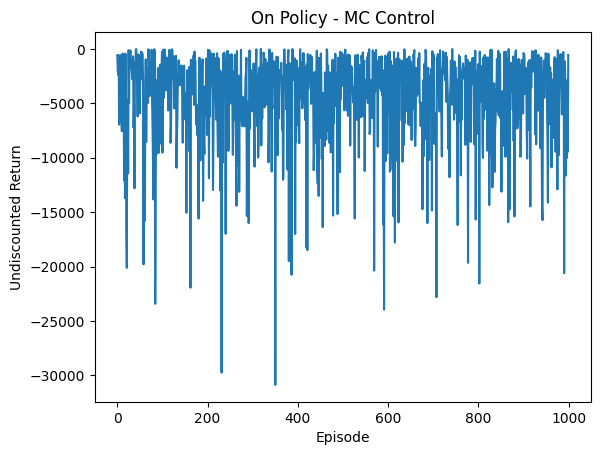

In [47]:
env = Environment("./racetrack2.csv")
agent_first_visit = Agent(env)
agent_first_visit.first_visit_mc()
agent_first_visit.print_action()
agent_first_visit.simulate_Q()
agent_first_visit.plot_rewards()

0 -3772
1 -1937
2 -7120
3 -2428
4 -2889
5 -10434
6 -6609
7 -8687
8 -3772
9 -6367
10 -267
11 -18256
12 -132
13 -1676
14 -5699
15 -6283
16 -11522
17 -15578
18 -1177
19 -2130
20 -9451
21 -3716
22 -8918
23 -5123
24 -5831
25 -1270
26 -1813
27 -6605
28 -4101
29 -6949
30 -7903
31 -1400
32 -1990
33 -3158
34 -6741
35 -3290
36 -783
37 -1525
38 -3
39 -8204
40 -10073
41 -13799
42 -2774
43 -3937
44 -3163
45 -7853
46 -4346
47 -2304
48 -1265
49 -1780
50 -1174
51 -5308
52 -2400
53 -3909
54 -12
55 -17474
56 -3297
57 -2454
58 -125
59 -9752
60 -1837
61 -1469
62 -1524
63 -2526
64 -1880
65 -5076
66 -6529
67 -6351
68 -1843
69 -1922
70 -171
71 -2103
72 -12587
73 -973
74 -530
75 -3714
76 -935
77 -696
78 -8025
79 -904
80 -187
81 -4608
82 -4342
83 -7311
84 -334
85 -4713
86 -6177
87 -2122
88 -3948
89 -4160
90 -697
91 -1761
92 -5954
93 -4660
94 -8467
95 -4696
96 -7818
97 -1276
98 -4114
99 -1748
100 -931
101 -487
102 -22480
103 -1099
104 -1611
105 -1635
106 -5483
107 -4895
108 -5238
109 -2289
110 -937
111 -7175
11

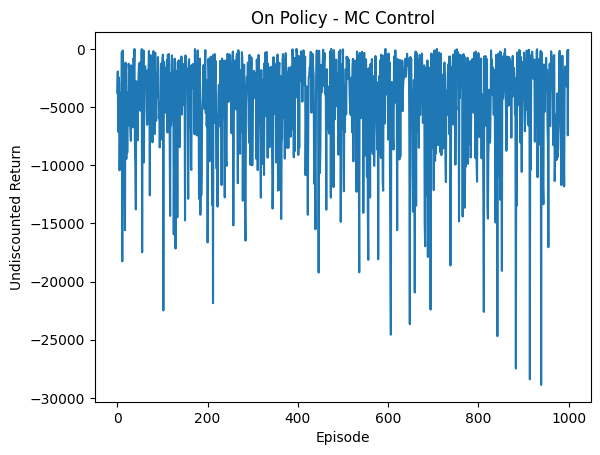

In [48]:
agent_every_visit = Agent(env)
agent_every_visit.every_visit_mc()
agent_every_visit.print_action()
agent_every_visit.simulate_Q()
agent_every_visit.plot_rewards()